In [59]:
import os
import matplotlib.pyplot as plt
import numpy as np
from fastai.vision.all import *
import torch
import skimage
from PIL import Image

In [60]:
def es_correcta(imagen): return imagen[0] == 'B'

In [61]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='Nearest')

In [62]:
class RuidoScikit(object):
    """Clase para aplicar ruido gausiano mediante sci-kit."""
    def __init__(self,mode,seed):
        self.mode = mode
        self.seed = seed

    def __call__(self, image):
        image = np.asarray(image)
        image = skimage.util.random_noise(image, mode=self.mode , seed=self.seed)
        #image = Image.fromarray(np.uint8(image * 255)  , 'L')
        return image

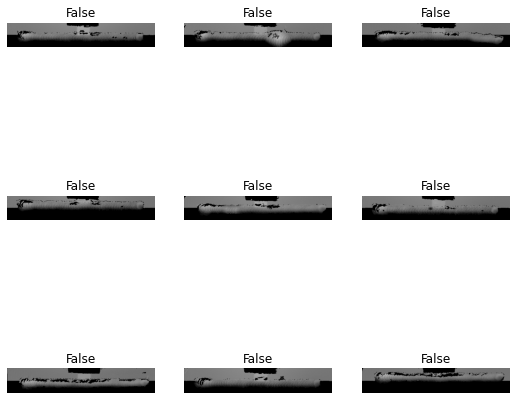

In [66]:
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# # imagen = Image.open(Path('/home/yani/TFG-Dataset/DatasetConIncorrectas/Tipo2/Completo/BDia_1_Pieza_15_Soldadura_42.png'))

# # rotacion = Rotate(p=1., draw=180)

# # atensor = transforms.ToTensor()
# # aimagen = transforms.ToPILImage()
# # imagen = aimagen(rotacion(atensor(imagen)))
# # imagen

# path = '/home/yani/TFG-Dataset/DatasetConIncorrectas/Tipo2/Completo/'
# items = get_image_files(path)[:4]
# #print(f"items:{items}")

# imagenes = []
# for image in items:
#     imagen = Image.open(image)
#     atensor = transforms.ToTensor()
#     #display(imagen)
#     imagenes.append(atensor(imagen))
#     # imagenes.append(tensor(imagen).squeeze(1))
# #print(imagenes[1].size())

# grid = make_grid(imagenes).shape
# plt.figure(figsize = (20,2))
# plt.imshow(np.transpose(make_grid(imagenes),(1,2,0)))
# #plt.imshow(make_grid(imagenes))

# # TODO : Usar las TFMDLists de fastai para hacer una serie de tranformaciones al dataset.


# items = get_image_files(path)[:4]
# imagenes2 = []
# for i in items:
#     imagen = Image.open(i)
#     imagenes2.append(imagen)


# ruido = RuidoScikit('gaussian' , 42)
# prueba = ruido(imagenes2[0])
# #prueba = Image.fromarray(np.uint8(prueba * 255)  , 'L')
# print(type(prueba))
# display(prueba)

path = Path('/home/yani/TFG-Dataset/DatasetConIncorrectas/Tipo2/Completo')
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, bs=10, seed=42,
    label_func=es_correcta
)


# # img_list = []
# # for i in range(4):
# #     img_list.append(dls.__getitem__(i)[0])
# # show(make_grid(img_list))
dls.show_batch()

In [67]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.065772,0.021085,0.995685,01:00


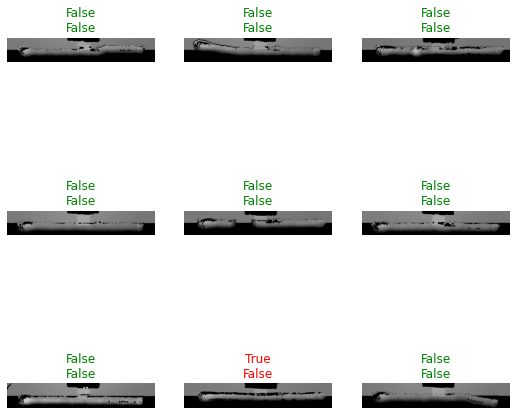

In [68]:
learn.show_results()

epoch,train_loss,valid_loss,accuracy,time
0,1.113406,53.625648,0.266451,00:59
1,0.884377,0.498537,0.838188,01:00
2,1.677968,3090.448242,0.631068,01:00
3,0.761832,141.511856,0.842503,01:00
4,0.542599,1.004713,0.838188,01:01
5,0.423756,0.559243,0.852211,01:00
6,0.257445,0.194168,0.909385,01:01
7,0.132566,372.932892,0.911543,01:00
8,0.090129,15.682178,0.922330,01:01
9,0.115464,2.259624,0.970874,01:01


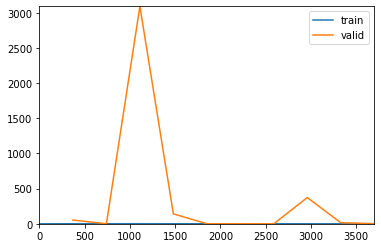

In [69]:
learn.fit_one_cycle(10, slice(5e-3,5e-2),cbs=[ShowGraphCallback()]) 

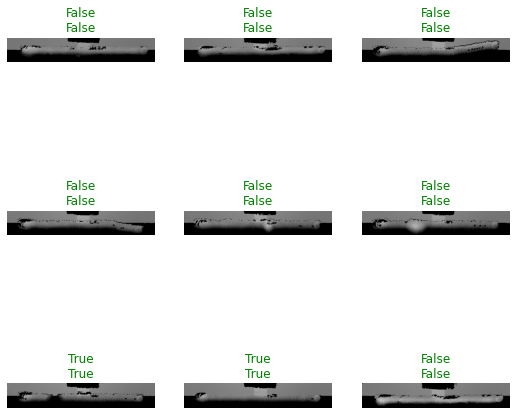

In [70]:
learn.show_results()